In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
import keras
import os
import cv2
import pickle
import random

In [3]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import batch_normalization
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential
from matplotlib.image import imread
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns


Data Path

In [4]:
train = r'D:/tomato/train'
test = r'D:/tomato/val'
size=224

In [5]:
train_images = []
train_labels = []
for directory_path in glob.glob('D:/tomato/train/*'):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(256,256))
        train_images.append(img)
        train_labels.append(label)

Tomato___Bacterial_spot
Tomato___healthy
Tomato___Late_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [6]:
test_images = []
test_labels = []
for directory_path in glob.glob('D:/tomato/val/*'):
    label = directory_path.split("\\")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(256,256))
        test_images.append(img)
        test_labels.append(label)

In [7]:
datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)

In [8]:
X_train = ImageDataGenerator(rescale=1./255).flow_from_directory(train,
                                      target_size=(size,size),
                                      batch_size=32,
                                      class_mode='categorical',
                                      subset='training')
X_test = ImageDataGenerator(rescale=1./255).flow_from_directory(test,
                                     target_size=(size,size),
                                     batch_size=32,
                                     class_mode='categorical',
                                     subset='training')

Found 2500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


**Importing MobileNetV3**

In [9]:
from keras.applications import MobileNetV3Large

In [10]:
mobNet_model = MobileNetV3Large(weights='imagenet', include_top=False,input_shape=(size,size,3))

In [11]:
for layer in mobNet_model.layers:
    layer.trainable = False

Callbacks and EarlyStoping

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint=ModelCheckpoint(r'model70epochs.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)
callbacks=[checkpoint,earlystop]

In [13]:
mobNet_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [14]:
x = Flatten()(mobNet_model.output)
prediction = Dense(len(X_test.class_indices.keys()),activation='softmax')(x)
mobNet_model = Model(inputs=mobNet_model.input, outputs = prediction)
mobNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
mobNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
history= mobNet_model.fit(x=X_train, validation_data=X_test,
                    epochs=5,
                    steps_per_epoch=X_train.samples//32,
                    validation_steps=X_test.samples//32,
                    callbacks=callbacks)

Epoch 1/5
78/78 [==============================] - ETA: 0s - loss: 1.7656 - accuracy: 0.3387
Epoch 1: val_loss improved from inf to 1.40775, saving model to model70epochs.h5
78/78 [==============================] - 46s 547ms/step - loss: 1.7656 - accuracy: 0.3387 - val_loss: 1.4078 - val_accuracy: 0.3521
Epoch 2/5
78/78 [==============================] - ETA: 0s - loss: 1.2593 - accuracy: 0.4810
Epoch 2: val_loss improved from 1.40775 to 1.26636, saving model to model70epochs.h5
78/78 [==============================] - 42s 531ms/step - loss: 1.2593 - accuracy: 0.4810 - val_loss: 1.2664 - val_accuracy: 0.4833
Epoch 3/5
78/78 [==============================] - ETA: 0s - loss: 1.0617 - accuracy: 0.5798
Epoch 3: val_loss improved from 1.26636 to 1.10030, saving model to model70epochs.h5
78/78 [==============================] - 42s 540ms/step - loss: 1.0617 - accuracy: 0.5798 - val_loss: 1.1003 - val_accuracy: 0.5562
Epoch 4/5
78/78 [==============================] - ETA: 0s - loss: 1.0162 

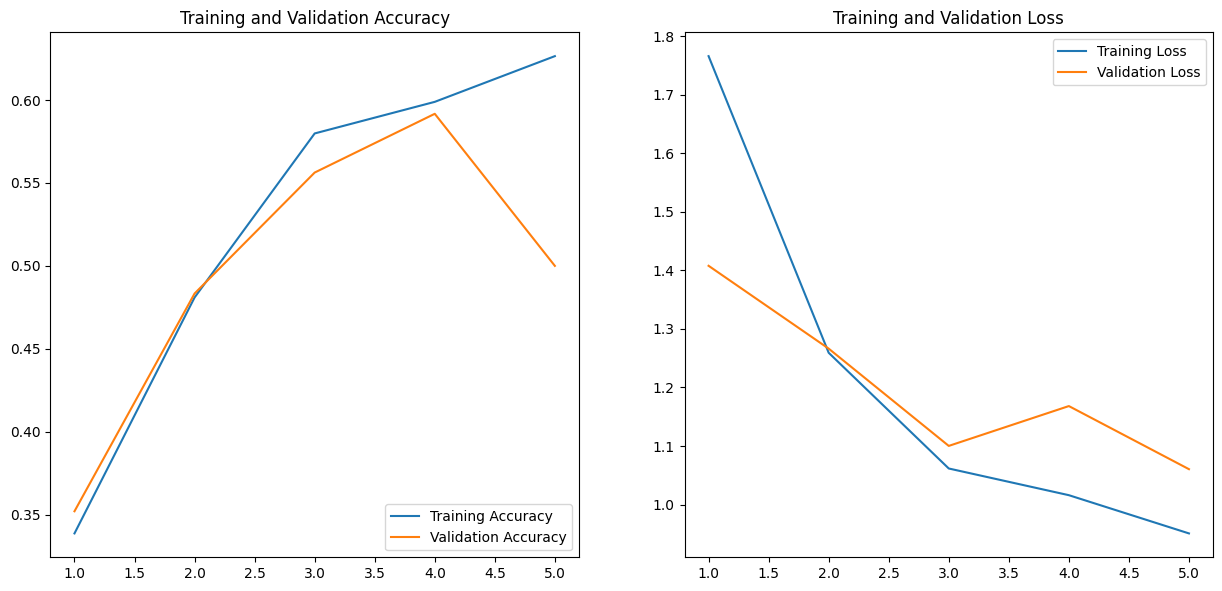

Maximum Training Accuracy Score =>  62.64181733131409
Maximum Validation Accuracy Score =>  59.16666388511658


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1,6)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("Maximum Training Accuracy Score => ",max(acc)*100)
print("Maximum Validation Accuracy Score => ",max(val_acc)*100)

**Importing NasNet** 

In [18]:
from keras.applications import NASNetMobile #Indha model OK mass ah iruku accuracy

In [19]:
nas_model = NASNetMobile(weights='imagenet', include_top=False,input_shape=(size,size,3))

In [20]:
for layer in nas_model.layers:
    layer.trainable = False

In [21]:
nas_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                            

In [22]:
x = Flatten()(nas_model.output)
prediction = Dense(len(X_test.class_indices.keys()),activation='softmax')(x)
nas_model = Model(inputs=nas_model.input, outputs = prediction)
nas_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                           

In [23]:
nas_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [24]:
history= nas_model.fit(x=X_train, validation_data=X_test,
                    epochs=5,
                    steps_per_epoch=X_train.samples//32,
                    validation_steps=X_test.samples//32,
                    callbacks=callbacks)

Epoch 1/5
75/78 [===========================>..] - ETA: 2s - loss: 2.9949 - accuracy: 0.7340

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1,6)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("Maximum Training Accuracy Score => ",max(acc)*100)
print("Maximum Validation Accuracy Score => ",max(val_acc)*100)

NameError: name 'history' is not defined

**Importing InceptionResNetV2**

In [ ]:
from keras.applications import InceptionResNetV2

In [ ]:
IRN_model = InceptionResNetV2(weights='imagenet', include_top=False,input_shape=(size,size,3))

In [ ]:
for layer in IRN_model.layers:
    layer.trainable = False

In [ ]:
IRN_model.summary()

In [ ]:
x = Flatten()(IRN_model.output)
prediction = Dense(len(X_test.class_indices.keys()),activation='softmax')(x)
IRN_model = Model(inputs=IRN_model.input, outputs = prediction)
IRN_model.summary()

In [ ]:
IRN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
history= IRN_model.fit(x=X_train, validation_data=X_test,
                    epochs=5,
                    steps_per_epoch=X_train.samples//32,
                    validation_steps=X_test.samples//32,
                    callbacks=callbacks)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1,6)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("Maximum Training Accuracy Score => ",max(acc)*100)
print("Maximum Validation Accuracy Score => ",max(val_acc)*100)